In [220]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os, time
import re
import pandas as pd
from astropy.io import fits
from astropy.wcs import WCS
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus
from astroquery.astrometry_net import AstrometryNet
from astroquery.exceptions import TimeoutError
from a345_utilities import print_header 
from astropy.time import Time
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.coordinates.angles import Angle
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astroquery.sdss import SDSS
from astropy import coordinates as coords
from astropy.table import QTable
from astropy.stats import sigma_clipped_stats
import ccdproc
import warnings
warnings.filterwarnings('ignore')  


# Main Platesolving server
ast = AstrometryNet()
ast.API_URL = 'http://nova.astro.gla.ac.uk/api' 
ast.api_key = 'XXXXXXXX'
ast.URL = 'http://nova.astro.gla.ac.uk'

# Backup server on Ettus - use this as a back-up if there are issues with the primary server 
# ast.API_URL = 'http://ettus3.astro.gla.ac.uk:8000/api' # local server
# ast.URL = 'http://ettus3.astro.gla.ac.uk:8000'
# ast.api_key = 'XXXXXXXX'




In [229]:

# Define paths for calibration files, data and platesolved images
cal_path = '/Volumes/external_2T/calibration/2023-10/neg10c/master/'
data_path = '/Volumes/external_2T/'
plate_path = data_path + 'platesolved_img/'


EXPOSURE = '10s'      #Define the exposure of the images to calibrate
STAR_NAME = 'W UMa'      # Define star name
FAILURES = False

In [230]:

# Define platesolve function that takes exposure and star name
def platesolve(exposure = EXPOSURE, star_name = STAR_NAME, failures = FAILURES):


    '''
    Takes exposure as a string with `s` on the end of number
    takes star name as a string

    opens fits files for calibration runs calibration on each image, before using DAO star finder to locate and platesolve each image
    '''


    # loading in flats for use
    with fits.open(cal_path + 'flat_i_master.fits') as hdu:
        flat_i = hdu[0].data
    with fits.open(cal_path + 'flat_g_master.fits') as hdu:
        flat_g = hdu[0].data
    with fits.open(cal_path + 'flat_r_master.fits') as hdu:
        flat_r = hdu[0].data


    # load flat dark file for use in calibration
    with fits.open(cal_path + 'dark_flat_gr_3s_master.fits') as hdu:
        flat_dark = hdu[0].data


    stars = os.listdir(data_path)

    for star in stars:
        if re.search(star_name, star):

            col_band = os.listdir(data_path + star)
            
            col_band = col_band[1:]

            for band in col_band:
                
                if band.endswith('I'):
                    flat = flat_i
                    print('i')
                elif band.endswith('G'):
                    flat = flat_g
                    print('g')
                elif band.endswith('R'):
                    flat = flat_r

                avg_flat_dark = np.mean(flat-flat_dark)
                if failures == True:
                    files = os.listdir(data_path + 'failed/' + star + '/' + band)
                else:
                    files = os.listdir(data_path + star + '/' + band)
                for file in files:



                    if re.search(exposure ,file):
                        with fits.open(cal_path + 'dark_' + exposure + '_master.fits') as hdu:
                            dark = hdu[0].data

                    if file.endswith('.fits'):

                        if failures == True:
                            with fits.open(data_path + 'failed/' + star + '/' + band + '/' + file) as hdu:
                                data = hdu[0].data
                                header = hdu[0].header

                        else: 
                            with fits.open(data_path + star + '/' + band + '/' + file) as hdu:
                                data = hdu[0].data
                                header = hdu[0].header

                        print(file)


                        if re.search('_E_0',file):

                            data = np.rot90(data)
                            data = np.rot90(data)

                        cali_img = ((data - dark)/(flat - flat_dark)) * avg_flat_dark
                        # plt.figure()
                        # plt.imshow(cali_img)
                        # plt.show()
                        # plt.figure()
                        # plt.imshow(data)
                        # plt.show()
                        data = cali_img  

                        bkg_sigma = mad_std(cali_img)                                    
                        daofind = DAOStarFinder(fwhm=6, threshold=18*bkg_sigma)    

                        sources = daofind(cali_img)  
                        for col in sources.colnames:  
                            sources[col].info.format = '%.6g' 


                        sources.sort('flux') 
                        sources.reverse()   
                        sources  
                        wcs = WCS(header)





                        image_width, image_height = data.shape
                        wcs_header = None           
                        t_start = time.time() 
                        try:
                                print('Sending data to AstrometryNet server:')
                                wcs_header = ast.solve_from_source_list(sources['xcentroid'], sources['ycentroid'],
                                                                        image_width, image_height,
                                                                        solve_timeout=300000000000000000000)



                                if wcs_header:   
                                    print('\n -> Success. Solving took {:0.1f}s'.format(time.time()-t_start))
                                    # print_header(wcs_header)        
                                    header.update(wcs_header) 


                                    # hdu = fits.PrimaryHDU(data)         # create a FITS HDU object

                                    # hdu.header.update(wcs_header)       # add in the header containg the wcs data
                                    # hdu.writeto(data_path + 'platesolved_img/' + star + '/' + band + '/' + '_platesolved_' + file, overwrite = True)
                                    if not os.path.exists(data_path + 'platesolved_img/' + star + '/' + band):
                                        os.makedirs(data_path + 'platesolved_img/' + star + '/' + band)
                                    header.update(wcs_header)   # add in the solved WCS info   
                                    hdu = fits.PrimaryHDU(cali_img)         # create a FITS HDU object

                                    hdu.header.update(wcs_header)       # add in the header containg the wcs data
                                    hdu.writeto(data_path + 'platesolved_img/' + star + '/' + band + '/' + '_platesolved_' + file, overwrite = True)


                                else:
                                    print('\n -> Solving failed after {:0.1f}s'.format(time.time()-t_start)) 
                                    if not os.path.exists(data_path + 'failed/' + star + '/' + band):
                                        os.makedirs(data_path + 'failed/' + star + '/' + band)
                                    os.rename(data_path + star + '/' + band + '/' + file, data_path + 'failed/' + star + '/' + band + '/'  + file)
                        except TimeoutError:       
                                print('\n -> ##FAIL: Timeout while solving, try a longer timeout, optmise number of sources (200-800 seems about right)')


In [231]:
platesolve()

g
W-UMa_LIGHT_2024-01-23T20-55-56Z_Chr-G_10s_-10.0C_W_0007.fits
Sending data to AstrometryNet server:
Solving......................
 -> Success. Solving took 24.6s
W-UMa_LIGHT_2024-01-23T23-07-10Z_Chr-G_10s_-9.9C_W_0022.fits
Sending data to AstrometryNet server:
Solving...
 -> Success. Solving took 3.4s
W-UMa_LIGHT_2024-01-24T01-18-25Z_Chr-G_10s_-10.0C_W_0037.fits
Sending data to AstrometryNet server:
Solving.....
 -> Success. Solving took 5.7s
W-UMa_LIGHT_2024-01-23T21-48-19Z_Chr-G_10s_-10.0C_W_0013.fits
Sending data to AstrometryNet server:
Solving......
 -> Success. Solving took 7.7s
W-UMa_LIGHT_2024-01-24T01-27-15Z_Chr-G_10s_-10.0C_W_0038.fits
Sending data to AstrometryNet server:
Solving...
 -> Success. Solving took 4.1s
W-UMa_LIGHT_2024-01-24T00-08-23Z_Chr-G_10s_-10.0C_W_0029.fits
Sending data to AstrometryNet server:
Solving.....
 -> Success. Solving took 5.5s
W-UMa_LIGHT_2024-01-24T02-06-00Z_Chr-G_10s_-10.0C_E_0042.fits
Sending data to AstrometryNet server:
Solving.....
 -> Suc

In [205]:
mag_dic_g = {
'target_mag':[] ,
'cali_mag':[],
'Julian Date':[],
'time':[],
}

mag_dic_i = {
'target_mag':[] ,
'cali_mag':[],
'Julian Date':[],
'time':[],
}
mag_dic_r = {
'target_mag':[] ,
'cali_mag':[],
'Julian Date':[],
'time':[],
}

def aperture(exposure = EXPOSURE, star_name = STAR_NAME):
    '''
    Takes exposure as a string with `s` on the end of number
    takes star name as a string

    Takes pre calibrated and platesolved images and extracts flux and magnitudes for the target star, as well as time/julian dates
    '''

    cali_stars = np.loadtxt(data_path + 'cal_stars/' + star_name + '_calibration_stars.txt', delimiter = ',', skiprows=1)

    id = cali_stars[:,0]
    Ra = cali_stars[:,1]
    De = cali_stars[:,2]
    gmag = cali_stars[:,3]
    g_err = cali_stars[:,4]
    rmag = cali_stars[:,5]
    r_err = cali_stars[:,6]
    imag = cali_stars[:,7]
    i_err = cali_stars[:,8]


    counter = 0
    stars = os.listdir(data_path)
    for star in stars:
        if re.search(star_name, star):

            col_band = os.listdir(plate_path + star)
            
            col_band = col_band[1:]
                
            for band in col_band:
                


                files = os.listdir(data_path + 'platesolved_img/' + star + '/' + band)
                for file in files:

                    counter +=1


                    if re.search(exposure ,file):
                        dark = fits.open(cal_path + 'dark_' + exposure + '_master.fits')[0].data
                        
                    if file.endswith('.fits'):
                        with fits.open(data_path + 'platesolved_img/' + star + '/' + band + '/' + file) as hdu:
                            data = hdu[0].data
                            header = hdu[0].header
                            
                        bkg_sigma = mad_std(data)                                    # get a measure of the image noise level
                        daofind = DAOStarFinder(fwhm=6, threshold=20*bkg_sigma)     # set the detection threshold for a source based on the image noise
                        #             IRAFstarfinder()
                                                                                    # a lower theshold will give more sources, but will start picking up noise
                        sources = daofind(data)  
                        for col in sources.colnames:  
                            sources[col].info.format = '%.6g'  # for consistent table output 


                        sources.sort('flux') # sources are sorted by y position, more useful to sort them by flux
                        sources.reverse()    # reverse order so list is in decending order of flux
                        sources  
                        wcs = WCS(header)

                        # print(sources)


                        N_source=20

                        N_cal=2

                        # plt.figure(figsize=(10,18))
                        # plt.subplot(projection = wcs)


                        positions_dao = np.transpose((sources['xcentroid'], sources['ycentroid']))  
                        apertures_define = CircularAperture(positions_dao, r=25)
                        apertures_dao=apertures_define[0:N_source+1]
                        apertures_dao.plot(color='yellow', lw=1)

                        for j,p in enumerate(positions_dao[0:N_source+1]):
                            plt.text(p[0]+20,p[1],sources['id'][j],fontsize=12,color='yellow')

                        r1=20
                        r2=r1+2
                        r3=r2+4

                        source1_x, source1_y = wcs.wcs_world2pix(Ra,De,1)
                        source1 = np.transpose((source1_x, source1_y))
                        source1_aperture = CircularAperture(source1, r1)  
                        source1_annulus = CircularAnnulus(source1, r2, r3)

                        source1_phot = [source1_aperture, source1_annulus]
                        source1_aperture.plot(color='blue', lw=2, alpha=1)
                        source1_annulus.plot(color='deepskyblue', lw=2, alpha=1)

                        for k in range(N_cal):
                            plt.text(source1_x[k]-50,source1_y[k]-50,id[k],fontsize=14,color='blue')

                        mean_intensity = np.mean(data)
                        r = 200

                        # plt.imshow(data,vmin=mean_intensity, vmax = mean_intensity+r, cmap='gray')    
                        # plt.grid(color='lightblue', ls='solid')    
                        # plt.set_cmap('gray')

                        # plt.gca().invert_yaxis()



                        target_x = sources['xcentroid'][0]
                        target_y = sources['ycentroid'][0]

                        # source2_x, source2_y = wcs.wcs_world2pix(15*(7+23/60+35.6/3600),29+43/60+45/3600, 1)
                        # source2_x, source2_y =(503.00169 , 491.50421 )

                        Coor_x, Coor_y = wcs.wcs_pix2world(target_x, target_y, 1)
                        # print(target_x,target_y)
                        # print(Coor_x,Coor_y)
                        # sky_Coor=SkyCoord(Coor_x*u.degree,Coor_y*u.degree)
                        # print(sky_Coor.to_string('hmsdms'))

                        #obj_asteroid = np.transpose((pixel_x, pixel_y))  
                        target=np.transpose((target_x, target_y))
                        target_aperture = CircularAperture(target, r1)  
                        target_aperture.plot(color='red', lw=2, alpha=1)

                        target = np.transpose((target_x, target_y))
                        target_aperture = CircularAperture(target, r1)  
                        target_annulus = CircularAnnulus(target, r2, r3)

                        target_phot = [target_aperture, target_annulus]
                        target_aperture.plot(color='red', lw=2, alpha=1)
                        target_annulus.plot(color='lightcoral', lw=2, alpha=1)

                        # plt.show()


                        phot_table_target = aperture_photometry(data, target_phot)
                        phot_table_cali = aperture_photometry(data, source1_phot)

                        for col in phot_table_cali.colnames:
                            phot_table_cali[col].info.format = '%.8g'  # for consistent table output
                        # print(phot_table_cali)

                        # print('************ Cal 1/Cal 2 *************')
                        bkg_mean_cal1 = float(phot_table_cali[0]['aperture_sum_1'] / source1_annulus.area)
                        bkg_mean_cal2 = float(phot_table_cali[1]['aperture_sum_1'] / source1_annulus.area)

                        # print('mean bkg Cal 1=',bkg_mean_cal1)
                        # print('mean bkg Cal 2=',bkg_mean_cal2)

                        bcal1 = bkg_mean_cal1 * source1_aperture.area
                        bcal2 = bkg_mean_cal2 * source1_aperture.area
                        # background removed counts
                        cal1_flux=float(phot_table_cali[0]['aperture_sum_0'] - bcal1)
                        cal2_flux=float(phot_table_cali[1]['aperture_sum_0'] - bcal2)

                        # print('Cal 1 flux=', cal1_flux)
                        # print('Cal 2 flux=', cal2_flux)

                        phot_table_source2 = aperture_photometry(data, target_phot)
                        for col in phot_table_source2.colnames:
                            phot_table_source2[col].info.format = '%.8g'  # for consistent table output
                        # print(phot_table_source2)

                        # print('************ Target *************')
                        bkg_mean_targ = float(phot_table_source2[0]['aperture_sum_1'] / target_annulus.area)

                        # print('mean bkg target=',bkg_mean_targ)

                        targcal = bkg_mean_targ * target_aperture.area
                        # background removed counts
                        targ_flux=float(phot_table_source2[0]['aperture_sum_0'] - targcal)
                        # print('Target flux=', targ_flux)

                        mag_cal=gmag[0] + 2.5*np.log10(cal1_flux/cal2_flux)
                        mag_targ=gmag[0] + 2.5*np.log10(cal1_flux/targ_flux)

                        # print('......')

                        t_fits=header['DATE']
                        t = Time(t_fits, format='isot', scale='utc')
                        t_jd=t.jd 

                        # print(t_fits,t_jd,mag_cal,mag_targ)



                        if band.endswith('I'):
                            mag_dic_i['cali_mag'].append(mag_cal)
                            mag_dic_i['target_mag'].append(mag_targ)
                            mag_dic_i['Julian Date'].append(t_jd)
                            mag_dic_i['time'].append(t_fits)
                        elif band.endswith('G'):
                            mag_dic_g['cali_mag'].append(mag_cal)
                            mag_dic_g['target_mag'].append(mag_targ)
                            mag_dic_g['Julian Date'].append(t_jd)
                            mag_dic_g['time'].append(t_fits)
                        elif band.endswith('R'):
                            mag_dic_r['cali_mag'].append(mag_cal)
                            mag_dic_r['target_mag'].append(mag_targ)
                            mag_dic_r['Julian Date'].append(t_jd)
                            mag_dic_r['time'].append(t_fits)




    print(counter)






    target_mag   cali_mag   Julian Date                 time
0     8.620283  11.915334  2.460368e+06  2024-02-27T16:15:15
1     7.976310  11.910339  2.460368e+06  2024-02-27T16:15:21
2     8.421460  11.939480  2.460368e+06  2024-02-27T16:15:27
3     8.115080  11.864951  2.460368e+06  2024-02-27T16:15:33
4     8.341987  11.960552  2.460368e+06  2024-02-27T16:15:40
5     8.301788  11.896543  2.460368e+06  2024-02-27T16:15:51
6     8.138577  11.903101  2.460368e+06  2024-02-27T16:15:57
7     8.527585  11.874122  2.460368e+06  2024-02-27T16:16:03
8     7.957343  11.903142  2.460368e+06  2024-02-27T16:16:09
9     8.518319  11.956237  2.460368e+06  2024-02-27T16:16:21
10    8.033089  11.908211  2.460368e+06  2024-02-27T16:16:28
11    8.101505  11.889183  2.460368e+06  2024-02-27T16:16:34
12    8.617563  11.876460  2.460368e+06  2024-02-27T16:16:40
13    8.122145  11.952545  2.460368e+06  2024-02-27T16:16:46
14    8.336123  11.903132  2.460368e+06  2024-02-27T16:16:53
15    7.995704  11.91509

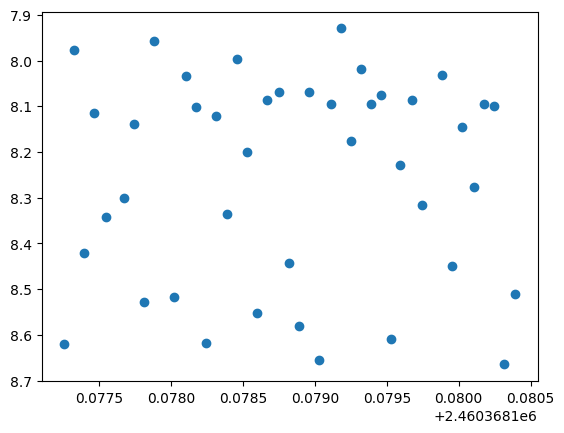

In [215]:

df = pd.DataFrame(mag_dic_g)

df.sort_values(by = ['Julian Date'], ascending=True, kind = 'quicksort', ignore_index = True, inplace = True, key = None)
plt.figure()
plt.scatter(df['Julian Date'],df['target_mag'])
print(df)
plt.gca().invert_yaxis()
# plt.xlim(0.005,0.06)

In [206]:
aperture()

53


ValueError: Image size of 504475x368482 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

In [ ]:
# APERTURE PHOTOMETRY
def aperture(exposure = EXPOSURE, star_name = STAR_NAME):
    counter = 0
    stars = os.listdir(data_path)
    for star in stars:
        if re.search(star_name, star):

            col_band = os.listdir(plate_path + star)
            
            col_band = col_band[1:]
                
            for band in col_band:
                


                files = os.listdir(data_path + 'platesolved_img/' + star + '/' + band)
                for file in files:

                    counter +=1


                    if re.search(exposure ,file):
                        dark = fits.open(cal_path + 'dark_' + exposure + '_master.fits')[0].data
                        
                    if file.endswith('.fits'):
                        with fits.open(data_path + 'platesolved_img/' + star + '/' + band + '/' + file) as hdu:
                            data = hdu[0].data
                            header = hdu[0].header

                            
                        bkg_sigma = mad_std(data)                                    # get a measure of the image noise level
                        daofind = DAOStarFinder(fwhm=6, threshold=20*bkg_sigma)     # set the detection threshold for a source based on the image noise
                        #             IRAFstarfinder()
                                                                                    # a lower theshold will give more sources, but will start picking up noise
                        sources = daofind(data)  
                        for col in sources.colnames:  
                            sources[col].info.format = '%.6g'  # for consistent table output 


                        sources.sort('flux') # sources are sorted by y position, more useful to sort them by flux
                        sources.reverse()    # reverse order so list is in decending order of flux
                        sources  

                        
                        phot_table_source1 = aperture_photometry(data, target_phot[0])
                        phot_table_source2 = aperture_photometry(data, cali_phot[0])

                        for col in phot_table_source1.colnames:
                            phot_table_source1[col].info.format = '%.8g'  # for consistent table output
                        print(phot_table_source1)

                        print('************ Cal 1/Cal 2 *************')
                        bkg_mean_cal1 = float(phot_table_source1[0]['aperture_sum_1'] / source1_annulus.area)
                        bkg_mean_cal2 = float(phot_table_source1[1]['aperture_sum_1'] / source1_annulus.area)

                        print('mean bkg Cal 1=',bkg_mean_cal1)
                        print('mean bkg Cal 2=',bkg_mean_cal2)

                        bcal1 = bkg_mean_cal1 * source1_aperture.area
                        bcal2 = bkg_mean_cal2 * source1_aperture.area
                        # background removed counts
                        cal1_flux=float(phot_table_source1[0]['aperture_sum_0'] - bcal1)
                        cal2_flux=float(phot_table_source1[1]['aperture_sum_0'] - bcal2)

                        print('Cal 1 flux=', cal1_flux)
                        print('Cal 2 flux=', cal2_flux)

                        phot_table_source2 = aperture_photometry(image_c, source2_phot)
                        for col in phot_table_source2.colnames:
                            phot_table_source2[col].info.format = '%.8g'  # for consistent table output
                        print(phot_table_source2)

                        print('************ Target *************')
                        bkg_mean_targ = float(phot_table_source2[0]['aperture_sum_1'] / source2_annulus.area)

                        print('mean bkg target=',bkg_mean_targ)

                        targcal = bkg_mean_targ * source2_aperture.area
                        # background removed counts
                        targ_flux=float(phot_table_source2[0]['aperture_sum_0'] - targcal)
                        print('Target flux=', targ_flux)

                        mag_cal=mag_cal1[0,0] + 2.5*np.log10(cal1_flux/cal2_flux)
                        mag_targ=mag_cal1[0,0] + 2.5*np.log10(cal1_flux/targ_flux)

                        print('......')

                        t_fits=hdu[0].header['DATE-OBS']
                        t = Time(t_fits, format='isot', scale='utc')
                        t_jd=t.jd 

                        print(t_fits,t_jd,mag_cal,mag_targ)

In [5]:
# plate_path = data_path + 'platesolved_img/'


# for star in stars:
#     if re.search(star_name, star):
#         col_band = os.listdir(data_path + star)
        
#         col_band = col_band[1:]
#         for band in col_band:
#             files = os.listdir(data_path + star + '/' + band)
#             for file in files:
#                 if file.endswith('.fits'):
#                     with fits.open(data_path + star + '/' + band + '/' + file) as hdu:
#                         data = hdu[0].data
#                         header = hdu[0].header

#                     d_mean = np.mean(data);    
#                     d_std  = np.std(data);     
#                     vmin = d_mean - d_std/2     
#                     vmax = d_mean + d_std   


#                     bkg_sigma = mad_std(data)                                    
#                     daofind = DAOStarFinder(fwhm=6, threshold=20*bkg_sigma)    

#                     sources = daofind(data)  
#                     for col in sources.colnames:  
#                         sources[col].info.format = '%.6g' 


#                     sources.sort('flux') 
#                     sources.reverse()   
#                     sources  
#                     wcs = WCS(header)
# #                     lin = np.linspace(0,1000,1)
# #                     for i in np.arange(lin):
# #                         for j in np.arange(lin):
# #                             emp[i][j] + data[i][j]

# # plt.figure()
# # plt.imshow(emp)
# # # plt.show()

# #                     fig2 = plt.figure(figsize=(16,10))
# #                     plt.imshow(data, vmin = vmin, vmax=vmax, cmap='gray_r')

# #                     # for each source plot a circular aperture, radius 8 pixels (these are normally used for photometry, but useful for plotting sources too)
# #                     positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
# #                     apertures = CircularAperture(positions, r=30)  
# #                     p = apertures.plot(color='blue', lw=1.5, alpha=0.5)
# #                     plt.show()

#                     image_width, image_height = data.shape
#                     wcs_header = None           
#                     t_start = time.time() 
#                     try:
#                             print('Sending data to AstrometryNet server:')
#                             wcs_header = ast.solve_from_source_list(sources['xcentroid'], sources['ycentroid'],
#                                                                     image_width, image_height,
#                                                                     solve_timeout=30000)



#                             if wcs_header:   
#                                 print('\n -> Success. Solving took {:0.1f}s'.format(time.time()-t_start))
#                                 # print_header(wcs_header)        
#                                 header.update(wcs_header) 
#                                 if re.search('_E_0',file):

#                                     data = np.rot90(data)
#                                     data = np.rot90(data)

#                                 # hdu = fits.PrimaryHDU(data)         # create a FITS HDU object

#                                 # hdu.header.update(wcs_header)       # add in the header containg the wcs data
#                                 # hdu.writeto(data_path + 'platesolved_img/' + star + '/' + band + '/' + '_platesolved_' + file, overwrite = True)

#                                 header.update(wcs_header)   # add in the solved WCS info   

#                                 # now save the calibrated file ready for analysis. This would normally be the end of a script like this:
#                                 # do any science analysis by loading the calibrated fits files from a different script

#                                 # The easiest way to save the fils file is to create a new  fits abject, and add the data and calibrated header 
#                                 hdu = fits.PrimaryHDU()         # create a FITS HDU object
#                                 hdu.data = data
#                                 hdu.header = header
#                                 hdu.header.update(wcs_header)       # add in the header containg the wcs data


#                                 hdu.writeto(data_path + 'platesolved_img/' + star + '/' + band + '/' + '_platesolved_' + file, overwrite = True)

#                                 # with fits.open(plate_path + star + '/' + band + '/' + '_platesolved_' + file) as dat:
#                                 #     data = dat[0].data
#                                 #     header = dat[0].header
#                             else:
#                                 print('\n -> Solving failed after {:0.1f}s'.format(time.time()-t_start)) 
#                                 if not os.path.exists(data_path + 'failed/' + star + '/' + band):
#                                     os.makedirs(data_path + 'failed/' + star + '/' + band)
#                                 os.rename(data_path + star + '/' + band + '/' + file, data_path + 'failed/' + star + '/' + band + '/'  + file)
#                     except TimeoutError:       
#                             print('\n -> ##FAIL: Timeout while solving, try a longer timeout, optmise number of sources (200-800 seems about right)')

#                         # get some colour limits














#                     # plt.figure(figsize=(10,18))
#                     # plt.subplot(projection = wcs)
#                     # mean_intensity = np.mean(data)
#                     # r = 200
#                     # plt.imshow(data,vmin=mean_intensity, vmax = mean_intensity+r, cmap='gray')    
#                     # plt.grid(color='lightblue', ls='solid')    

#                     # # flip the y-axis to get dec increasing to the top
#                     # plt.gca().invert_yaxis()
#                     # plt.show()






In [6]:
# cali_stars = np.loadtxt('calibration_stars.txt', delimiter = ',', skiprows=1)

# id = cali_stars[:,0]
# Ra = cali_stars[:,1]
# De = cali_stars[:,2]
# gmag = cali_stars[:,3]
# g_err = cali_stars[:,4]
# rmag = cali_stars[:,5]
# r_err = cali_stars[:,6]
# imag = cali_stars[:,7]
# i_err = cali_stars[:,8]


# for star in stars:
#     if re.search(star_name, star):
#         col_band = os.listdir(data_path + star)
        
#         col_band = col_band[1:]
#         for band in col_band:
#             files = os.listdir(plate_path + star + '/' + band)
#             for file in files:
#                 if file.endswith('.fits'):
#                     with fits.open(plate_path + star + '/' + band + '/' + file) as hdu:
#                         data = hdu[0].data
#                         header = hdu[0].header

                        
#                     d_mean = np.mean(data);    
#                     d_std  = np.std(data);     
#                     vmin = d_mean - d_std/2     
#                     vmax = d_mean + d_std   
#                     bkg_sigma = mad_std(data)                                    
#                     daofind = DAOStarFinder(fwhm=6, threshold=20*bkg_sigma)    

#                     sources = daofind(data)  
#                     for col in sources.colnames:  
#                         sources[col].info.format = '%.6g' 
#                     sources.sort('flux') 
#                     sources.reverse()   

#                     image_width, image_height = data.shape


#                     print(sources)
#                     N_source=20

#                     N_cal=2
#                     plt.figure(figsize=(10,18))
#                     plt.subplot(projection = wcs)
#                     positions_dao = np.transpose((sources['xcentroid'], sources['ycentroid']))  
#                     apertures_define = CircularAperture(positions_dao, r=25)
#                     apertures_dao=apertures_define[0:N_source+1]
#                     apertures_dao.plot(color='yellow', lw=1)

#                     for j,p in enumerate(positions_dao[0:N_source+1]):
#                         plt.text(p[0]+20,p[1],sources['id'][j],fontsize=12,color='yellow')

#                     r1=12
#                     r2=r1+1
#                     r3=r2+4

#                     source1_x, source1_y = wcs.wcs_world2pix(Ra,De,1)
#                     source1 = np.transpose((source1_x, source1_y))
#                     source1_aperture = CircularAperture(source1, r1)  
#                     source1_annulus = CircularAnnulus(source1, r2, r3)

#                     source1_phot = [source1_aperture, source1_annulus]
#                     source1_aperture.plot(color='blue', lw=2, alpha=1)
#                     source1_annulus.plot(color='deepskyblue', lw=2, alpha=1)

#                     for k in range(N_cal):
#                         plt.text(source1_x[k]-50,source1_y[k]-50,id[k],fontsize=14,color='blue')

#                     mean_intensity = np.mean(data)
#                     r = 200

#                     plt.imshow(data,vmin=mean_intensity, vmax = mean_intensity+r, cmap='gray')    
#                     plt.grid(color='lightblue', ls='solid')    
#                     plt.set_cmap('gray')

#                     plt.gca().invert_yaxis()
#                     plt.show()
#                     # break
 

In [2]:
# files = os.listdir(plate_path + 'W UMa' + '/' + 'CHr G')

# for file in files:
#     if file.endswith('.fits'):
#         with fits.open(plate_path + 'W UMa' + '/' + 'CHr G' + '/' + file) as hdu:
#             data = hdu[0].data
#             header = hdu[0].header



#         d_mean = np.mean(data);    
#         d_std  = np.std(data);     
#         vmin = d_mean - d_std/2     
#         vmax = d_mean + d_std   
#         bkg_sigma = mad_std(data)                                    
#         daofind = DAOStarFinder(fwhm=6, threshold=20*bkg_sigma)    

#         sources = daofind(data)  
#         for col in sources.colnames:  
#             sources[col].info.format = '%.6g' 
#         sources.sort('flux') 
#         sources.reverse()   
#         sources  
#         image_width, image_height = data.shape
#         N_source=20

#         N_cal=2
        
#         plt.figure(figsize = (10,18))
#         plt.subplot(projection = wcs)
#         positions_dao = np.transpose((sources['xcentroid'], sources['ycentroid']))  
#         apertures_define = CircularAperture(positions_dao, r=25)
#         apertures_dao=apertures_define[0:N_source+1]
#         apertures_dao.plot(color='yellow', lw=1)

#         # for j,p in enumerate(positions_dao[0:N_source+1]):
#         #     plt.text(p[0]+20,p[1],sources['id'][j],fontsize=12,color='yellow')

#         wcs = WCS(header)


#         plt.imshow(data,vmin=mean_intensity, vmax = mean_intensity+r, cmap='gray')    
#         plt.grid(color='lightblue', ls='solid')    
#         plt.set_cmap('gray')

#         plt.gca().invert_yaxis()
#         plt.show()
#         plt.show()